In [1]:
import random

import numpy as np
from sklearn.datasets import load_iris
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier


In [2]:
class Dense_Layer:
    def __init__(self, input_size, n_neurons):
        epsilon_init = 0.12
        # self.w = np.random.rand(input_size, n_neurons) * 2 * epsilon_init - epsilon_init
        self.input_size = input_size
        self.n_neurons = n_neurons
        self.w = np.random.RandomState(1).normal(loc=0.0, scale=0.1, size=(input_size, n_neurons))
        self.b = np.ones((1, n_neurons))
        # self.w = np.random.rand(input_size, n_neurons) * 0.01


        # Adam parameters
        #
        self.Vdw_prev = 0
        self.Vdb_prev = 0
        self.Sdw_prev = 0
        self.Sdb_prev = 0
        self.t = 1

        # epsilon_init = 0.12
        # self.w = np.random.rand(input_size, n_neurons) * 2 * epsilon_init - epsilon_init


    def forward(self, dense_input):
        self.z = np.dot(dense_input, self.w) + self.b
        return self.z

    def output_layer_forward(self, dense_input, adapter_bias=None):
        # print(self.b)
        # print(np.array(adapter_bias).ravel())
        # print(np.array(adapter_bias).ravel()*2)
        if adapter_bias != None:
          self.z = np.dot(dense_input, self.w) + ((self.b - np.array(adapter_bias).ravel()*0.5))
          # self.z = np.dot(dense_input, self.w) + ((self.b + adapter_bias) * (1/2))
        else:
          self.z = np.dot(dense_input, self.w) + self.b * 0.5

        
        return self.z

    def dropout(self, activation):
        self.keep_rate = 0.75
        # self.dropout2_mask = np.random.randn(activation.shape[0], activation.shape[1]) < self.keep_rate

        self.dropout_mask = np.ones(shape=(activation.shape[0], activation.shape[1])).reshape((1, -1)) == 1

        # print(self.dropout_mask)
        inactive_neurons = int(self.dropout_mask.shape[1] - (self.dropout_mask.shape[1] * self.keep_rate))
        inactive_neurons_indices = sorted(random.sample(range(0, self.dropout_mask.shape[1]), inactive_neurons))

        self.dropout_mask[0][inactive_neurons_indices] = 0
        self.dropout_mask = self.dropout_mask.reshape(activation.shape[0], activation.shape[1])

        # activation1 = (activation * self.dropout2_mask) / self.keep_rate
        activation *= self.dropout_mask
        return activation


    def adam(self, B1, B2, EPSILON, dw, db, eta):
        Vdw = B1 * self.Vdw_prev + (1 - B1) * dw
        Vdb = B1 * self.Vdb_prev + (1 - B1) * db

        # Vdw = Vdw / (1 - B1 ** self.t)
        # Vdb = Vdb / (1 - B1 ** self.t)

        self.Vdw_prev = Vdw
        self.Vdb_prev = Vdb

        Sdw = B2 * self.Sdw_prev + (1 - B2) * (dw ** 2)
        Sdb = B2 * self.Sdb_prev + (1 - B2) * (db ** 2)

        # Sdw = Sdw / (1 - B2 ** self.t)
        # Sdb = Sdb / (1 - B2 ** self.t)

        self.Sdw_prev = Sdw
        self.Sdb_prev = Sdb


        self.t += 1

        self.w -= eta * (Vdw / (sqrt(Sdw.sum()) + EPSILON))
        self.b -= eta * (Vdb / (sqrt(Sdb.sum()) + EPSILON))

    def adam_output(self, B1, B2, EPSILON, dw, db, eta):
        Vdw = B1 * self.Vdw_prev + (1 - B1) * dw
        Vdb = B1 * self.Vdb_prev + (1 - B1) * db

        # Vdw += 0.001
        # Vdw = Vdw / (1 - B1 ** self.t)
        # Vdb = Vdb / (1 - B1 ** self.t)

        self.Vdw_prev = Vdw
        self.Vdb_prev = Vdb

        Sdw = B2 * self.Sdw_prev + (1 - B2) * (dw ** 2)
        Sdb = B2 * self.Sdb_prev + (1 - B2) * (db ** 2)

        # Sdw = Sdw / (1 - B2 ** self.t)
        # Sdb = Sdb / (1 - B2 ** self.t)

        self.Sdw_prev = Sdw
        self.Sdb_prev = Sdb

        self.t += 1

        self.w -= eta * (Vdw / (sqrt(Sdw.sum()) + EPSILON))
        self.b -= eta * (Vdb / (sqrt(Sdb.sum()) + EPSILON))


class AtlasNN:

    def __init__(self, n_hidden=2, epochs=150, eta=0.005, l2=0.01, batch_size=5, seed=1, adapter_weights=None, adapter_bias=None):
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.epochs = epochs
        self.eta = eta
        self.l2 = l2
        self.random = np.random.RandomState(1)
        self.adapter_weights = adapter_weights
        self.adapter_bias = adapter_bias
        if self.adapter_weights != None:
          self.aaa = self.adapter_weights / np.sum(self.adapter_weights, axis=1, keepdims=True)
        self.i = 0

    def one_hot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
          onehot[val, idx] = 1.
        return onehot.T


    def relu(self, z):
        return np.maximum(0, z)
      
    def derivative_relu(self, x):
        return np.array(x > 0,  dtype=np.float32)

    def tanh(self, z):
      return np.tanh(z)

    def derivative_tanh(self, z):
        return (1 - np.power(z, 2))

    def sigmoid(self, z):
        return (1 / (1 + np.exp(-z)))

    def derivative_sigmoid(self, z):
        return z * (1 - z) 
    

    def softmax(self, z, x_data, y_data, num_examples):
        scores = z

        # print('result matrix')
        # print(scores.shape)

        # u, s, vt = np.linalg.svd(scores)

        # print('SVD properties')
        # print(u.shape)
        # print(s.shape)
        # print(vt.shape)
        # scores = z - np.max(z)

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # dscores = probs
        # print(dscores[range(num_examples), y_data])
        # dscores[range(num_examples), y_data] -= 1
        # dscores /= num_examples

        if self.adapter_weights != None:
          if self.i == 0:
            print('Activate Linear Adapter')
            self.i+=1
          probs = self.linear_adapter(probs, x_data, y_data)

        # print('linear results')
        # print(res)

        return probs
        # return res

    def cross_entropy_derivative(self, nn,y):
        nn = nn.clip(min=1e-8,max=None)
        #print('\n\nCED: ', np.where(y==1,-1/X, 0))
        return np.where(y==1,-1/nn, 0)

    def knn_proba(self, knn, x_data, labels):
        knn.fit(x_data, labels)
        print(knn.kneighbors_graph(x_data).toarray().shape)
        print(knn.get_params())
        print('knn trained!!')

    def linear_adapter(self, softmax_activation, x_data, y_data):

        f_activation = []
        result = []
        
        for sample in x_data:
          array = np.sum(self.adapter_bias + np.dot(sample, self.aaa.T), axis=0)
          f_activation.append([array[0], array[1], array[2]])
        
        # print(f_activation)
        f_function = np.array(f_activation).reshape((3, 3))
        # f_function /= np.sum(f_function, axis=1, keepdims=True)

        result = np.zeros((3, 3))
        # for i in range(softmax_activation.shape[0]):
        #    for j in range(softmax_activation.shape[1]):
        #       result[i][j] = softmax_activation[i][j] * f_activation[i][j]
        result = np.dot(softmax_activation, f_activation)
        # result /= np.sum(result, axis=1, keepdims=True)
        return result

    def fit(self, x_data, y_data, x_test_data, y_test_data):
        self.h1_layer = Dense_Layer(x_data.shape[1], 100)
        self.h2_layer = Dense_Layer(100, 100)
        self.h3_layer = Dense_Layer(100, 50)
        self.h4_layer = Dense_Layer(50, 50)
        self.output_layer = Dense_Layer(50, 3)

        step_size = self.eta
        reg = 0.02

        #Adam params
        B1 = 0.9
        B2 = 0.999
        EPSILON = 1e-10
        batch_size = 3#32

        self.train_scores = []
        self.test_scores = []

        # knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
        i = 0

        y_train_one_hot = self.one_hot(y_data, 3)

        for i in range(self.epochs):

            indices = np.arange(x_data.shape[0])
            np.random.shuffle(indices)

            for idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
              batch_idx = indices[idx:idx + batch_size]

              z1 = self.h1_layer.forward(x_data[batch_idx])
              h1 = self.sigmoid(z1)
              # h1 = self.h1_layer.dropout(h1)

              z2 = self.h2_layer.forward(h1)
              h2 = self.sigmoid(z2)
              h2 = self.h2_layer.dropout(h2)

              z3 = self.h3_layer.forward(h2)
              h3 = self.relu(z3)

              z4 = self.h4_layer.forward(h3)
              h4 = self.relu(z4)
              h4 = self.h4_layer.dropout(h4)

              z5 = self.output_layer.output_layer_forward(h4)

              # if i == 0:
              #   self.knn_proba(knn, x_data[batch_idx], y_data[batch_idx])
              #   i=i+1

              dscores = self.softmax(z5, x_data[batch_idx], y_data[batch_idx], x_data[batch_idx].shape[0])

              ###
              ##
              #   BACKPROPAGATION
              ##
              ###
              # print('dscores')
              # print(dscores)
              # print('real')
              # print(y_train_one_hot[batch_idx])
              dz_out = dscores - y_train_one_hot[batch_idx]
              dw_out = np.dot(h4.T, dz_out)
              db_out = np.sum(dscores, axis=0, keepdims=True)


              dz4 = np.dot(dz_out, self.output_layer.w.T) * self.derivative_relu(h4)
              dz4 = dz4 * self.h4_layer.dropout_mask
              dw4 = np.dot(h3.T, dz4)
              db4 = np.sum(dz4, axis=0, keepdims=True)

              dz3 = np.dot(dz4, self.h4_layer.w.T) * self.derivative_relu(h3)
              dw3 = np.dot(h2.T, dz3)
              db3 = np.sum(dz3, axis=0, keepdims=True)

              ###### hidden layer error #####
              dz2 = np.dot(dz3, self.h3_layer.w.T) * self.derivative_sigmoid(h2)
              # dh2[h2 <= 0] = 0

              # dh2 = dh2 * self.h2_layer.dropout_mask / self.h2_layer.keep_rate
              # self.h2_layer.dropout(dh2)

              #### !!!! dropout in backpropagation !!!!! ######
              dz2 = dz2 * self.h2_layer.dropout_mask
              dw2 = np.dot(h1.T, dz2)
              db2 = np.sum(dz2, axis=0, keepdims=True)

              ### -----> should be after of before gradient calculation <----- ####
              # dh2 = dh2 * self.h2_layer.dropout_mask

              ###### hidden layer error #####
              dz1 = np.dot(dz2, self.h2_layer.w.T) * self.derivative_sigmoid(h1)
              # dh1[dh1 <= 0] = 0

              # dh1 = dh1 * self.h1_layer.dropout_mask / self.h1_layer.keep_rate
              # dh1 = dh1 * self.h1_layer.dropout_mask
              # self.h1_layer.dropout(dh1)

              dw1 = np.dot(x_data[batch_idx].T, dz1)
              db1 = np.sum(dz1, axis=0, keepdims=True)

              # without - elipse decision boundary, with - straight line
              # dw_out += self.l2 * self.output_layer.w
              # dw2 += self.l2 * self.h2_layer.w

              self.h1_layer.adam_output(B1, B2, EPSILON, dw1, db1, step_size)

              self.h2_layer.adam(B1, B2, EPSILON, dw2, db2, step_size)

              self.h3_layer.adam(B1, B2, EPSILON, dw3, db3, step_size)

              self.h4_layer.adam(B1, B2, EPSILON, dw4, db4, step_size)

              self.output_layer.adam(B1, B2, EPSILON, dw_out, db_out, step_size)

            # train_pred = self.predict(x_data)
            # train_acc = accuracy_score(train_pred, y_train)
            # self.train_scores.append(train_acc)

            # test_pred = self.predict(x_test_data)
            # test_acc = accuracy_score(test_pred, y_test)
            # self.test_scores.append(test_acc)
            # print('accuracy: %.2f' % (np.mean(predicted_class == y_test_data)))

    def predict(self, x):
        z1 = self.h1_layer.forward(x)
        h1 = self.sigmoid(z1)

        z2 = self.h2_layer.forward(h1)
        h2 = self.sigmoid(z2)

        z3 = self.h3_layer.forward(h2)
        h3 = self.relu(z3)

        z4 = self.h4_layer.forward(h3)
        h4 = self.relu(z4)

        scores = self.output_layer.forward(h4)

        predicted_class = np.argmax(scores, axis=1)
        return predicted_class

    def predict_scores(self, x):
        z1 = self.h1_layer.forward(x)
        h1 = self.sigmoid(z1)

        z2 = self.h2_layer.forward(h1)
        h2 = self.sigmoid(z2)

        z3 = self.h3_layer.forward(h2)
        h3 = self.relu(z3)

        z4 = self.h4_layer.forward(h3)
        h4 = self.relu(z4)

        return self.output_layer.forward(h4)

    def plot_decision_regions(self, x, y, test_idx=None, resolution=0.05):
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # x = x[:, :2]
        x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        z = self.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        z = z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=a[cl],
                        edgecolors='black')
        plt.legend(loc='upper left')


In [3]:
iris = load_iris()
x = iris.data
y = iris.target

std = StandardScaler()
x = std.fit_transform(x)

[ -0.31514246 -14.95302602]
[-3.16291632 22.41035329]
(3, 1)
(4,)
(3, 2)
Result
[-16.44300347 -20.3190727  -22.56697013]
[ 11.24029907 -23.14612535]
[-16.01201568 -19.6517545  -24.43155689]
[ 11.24029907 -23.14612535]


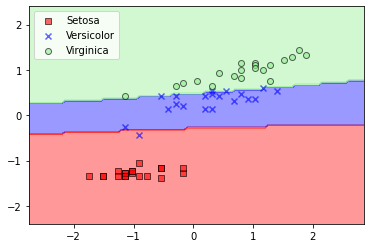

Train:  0.9333333333333333
Test:  0.9666666666666667


<ipython-input-4-ab925a4e660b>:115: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print('Train: ', np.sum(atlasNN.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
<ipython-input-4-ab925a4e660b>:116: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print('Test: ', np.sum(atlasNN.predict(x_test) == y_test).astype(np.float) / x

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm

def plot(x, y, lr, test_idx=None, resolution=0.02):
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # x = x[:, :2]
  x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
  np.arange(x2_min, x2_max, resolution))
  z = lr.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  z = z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=a[cl],
    edgecolors='black')
    plt.legend(loc='upper left')


x_train = x[:150, [0, 2]]
y_train = y[:150]

labels = np.unique(y_train)

# x_train = x[:100, [0, 2]]
# y_train = y[:100]

# epoch = 100
# atlasNN = AtlasNN(eta=0.11, epochs=epoch)

two_class_labels = []
weights_list = []
lr = LogisticRegression(C=1000.0, random_state=1)
clf = svm.SVC()
melted_weights = []
bias = []

for idx, val in enumerate(labels):
  two_class_labels = []
  for i in range(y.shape[0]):
    if y[i] == val:
      two_class_labels.append(1)
    else:
      two_class_labels.append(0)
  if val == 1:
    clf.fit(x_train, two_class_labels)
    # print(np.sum(clf.support_vectors_, axis=0))
    # plot(x_train, two_class_labels, clf)
    # plt.show()
    melted_weights.append(np.sum(clf.support_vectors_, axis=0))
    bias.append(clf.intercept_)
  else:
    lr.fit(x_train, two_class_labels)
    print(lr.coef_.ravel())
    # plot(x_train, two_class_labels, lr)
    # plt.show()
    melted_weights.append(lr.coef_.ravel())
    bias.append(lr.intercept_)


print(np.array(bias).shape)
print(x[149].shape)
print(np.array(melted_weights).shape)
print('Result')
# print((bias + np.dot(x[149, [0, 1, 2]].T, melted_weights)))

# q = np.array([[-16.44300347, -20.3190727,  -22.56697013],
#               [-16.01201568, -19.6517545,  -24.43155689],
#               [-15.78711386, -20.87569303, -24.23575341],
#               [-21.21341109, -15.57864768, -23.97031816],
#               [-20.433138,   -16.82906322, -22.26475414]])
q = np.array([[-16.44300347, -20.3190727,  -22.56697013],
              [-16.01201568, -19.6517545,  -24.43155689]])

for sample in q:
  print(sample)
  print(np.sum(bias + np.dot(x[23, [0, 1, 2]], melted_weights), axis=0))
# print(lr.coef_)
# print(np.sum(clf.support_vectors_, axis=0))
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=1, stratify=y)
 
# plt.savefig

# clf.fit(x_train, two_class_labels)
# plot(x_train, two_class_labels, clf)
# plt.show()

# lr.fit(x_train, two_class_labels)
# plot(x_train, two_class_labels, lr)
# plt.show()

epoch=500
# atlasNN = AtlasNN(eta=0.25019, epochs=epoch)
# atlasNN = AtlasNN(eta=0.003, epochs=epoch)
atlasNN = AtlasNN(eta=0.004, epochs=epoch)
# atlasNN.fit(x_train, np.array(two_class_labels), [], [], x_train.shape[1])

# atlasNN.plot_decision_regions(x_train, two_class_labels)
# plt.show()
atlasNN.fit(x_train, y_train, x_test, y_test)


# atlasNN.fit(x, y, [], [], x_train.shape[1])
atlasNN.plot_decision_regions(x_test, y_test)
plt.show()

print('Train: ', np.sum(atlasNN.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test: ', np.sum(atlasNN.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

In [5]:
class Destiller():
  def __init__(self, teacher, eta, epochs, adapter_weights=None, adapter_bias=None):
    self.teacher = teacher
    self.eta = eta
    self.epochs = epochs
    self.adapter_bias = adapter_bias
    self.adapter_weights = adapter_weights
    if self.adapter_weights != None:
      self.normazlied_adapter_weights = self.adapter_weights / np.sum(self.adapter_weights, axis=1, keepdims=True)
    self.i = 0
    self.logistic_regression = LogisticRegression(C=1000.0, random_state=1)

  def predict(self, x):
        z1 = self.h1_layer.forward(x)
        h1 = self.sigmoid(z1)

        z2 = self.h2_layer.forward(h1)
        h2 = self.sigmoid(z2)

        scores = self.output_layer.forward(h2)

        predicted_class = np.argmax(scores, axis=1)
        return predicted_class

  def sigmoid(self, z):
      return (1 / (1 + np.exp(-z)))

  def derivative_sigmoid(self, z):
      return z * (1 - z)

  def softmax(self, z, x_data=None, y_data=None):
        scores = z
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # if self.adapter_weights != None:
        #   if self.i == 0:
        #     print('Activate Linear Adapter')
        #     self.i+=1
        #   probs = self.linear_adapter(probs, x_data, y_data)

        if self.adapter_weights != None:
          probs = probs - self.eta * self.artemis_linear_adapter(probs, x_data, y_data)
        return probs

  def linear_adapter(self, softmax_activation, x_data, y_data):

        adapter_activation = []
        result = []
        
        for sample in x_data:
          array = np.sum(self.adapter_bias + np.dot(sample, self.normazlied_adapter_weights.T), axis=0)
          adapter_activation.append([array[0], array[1], array[2]])
        
        adapter_activation = np.array(adapter_activation).reshape((3, 3))
        # f_function /= np.sum(f_function, axis=1, keepdims=True)

        result = np.zeros((3, 3))
        for i in range(softmax_activation.shape[0]):
           for j in range(softmax_activation.shape[1]):
              result[i][j] = softmax_activation[i][j] * 1000 * adapter_activation[i][j]
        result /= np.sum(result, axis=1, keepdims=True)

        # return self.normazlied_adapter_weights
        return result

  def artemis_linear_adapter(self, softmax_activation, x_data, y_data):

    logistic_regression_results = []
    if len(np.unique(y_data) == 1):
      return 1
    for idx, unique_label in enumerate((np.unique(y_data))):
      logistic_labels = []
      for i, data_label in enumerate(y_data):
        if data_label == unique_label:
          logistic_labels.append(1)
        else:
          logistic_labels.append(0)
      try:
      # print(f'Labels for {unique_label}')
      # print(y_data)
      # print(logistic_labels)
        # indexes_to_remove = []
        # for idx, val in enumerate(logistic_labels):
        #   first_label = val[0]
        #   if len(val[val == first_label]) == len(val):
        #     indexes_to_remove.append(idx)
        
        # filtered_data = np.delete(x_data, indexes_to_remove, axis=0)
        # logistic_labels = np.delete(np.array(logistic_labels), indexes_to_remove, axis=0)

        logistic_regression_results.append(lr.fit(x_data, logistic_labels).coef_)
        # print(logistic_regression_results)
      except Exception as e:
        print("Logistic Regression exception occured: "+str(e))

    try:
      logistic_regression_matrix = np.vstack((logistic_regression_results[0], logistic_regression_results[1]))
      for i in range(logistic_regression_results):
        if i > 1 & i + 1 < logistic_regression_results.shape[1]:
          logistic_regression_matrix = np.vstack((logistic_regression_matrix, logistic_regression_results[i]))

      print(logistic_regression_matrix.shape)
    except Exception as e:
      print("Can not create linear matrix: "+str(e))
# 
    # if self.i == 0:
    #   print(logistic_regression_matrix)
    #   self.i += 1

  def student_loss_function(self, student_predictions, y):
    predicted_class = np.argmax(student_predictions, axis=1)
    return -y * np.log(student_predictions)


  def fit(self, x_data, y_data, temperature, alpha):

    # self.student.fit(x, y, x.shape[1])


    self.h1_layer = Dense_Layer(x_data.shape[1], 100)
    self.h2_layer = Dense_Layer(100, 50)
    self.output_layer = Dense_Layer(50, 3)

    step_size = self.eta
    reg = 0.02

        #Adam params
    B1 = 0.9
    B2 = 0.999
    EPSILON = 1e-10
    batch_size = 3#32

    self.train_scores = []
    self.test_scores = []
    i = 0

    y_train_one_hot = self.teacher.one_hot(y_data, 3)

    for i in range(self.epochs):

        indices = np.arange(x_data.shape[0])
        np.random.shuffle(indices)

        for idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
          batch_idx = indices[idx:idx + batch_size]

          teacher_predictions = self.teacher.one_hot(self.teacher.predict(x_data[batch_idx]), 3)

          z1 = self.h1_layer.forward(x_data[batch_idx])
          h1 = self.sigmoid(z1)

          z2 = self.h2_layer.forward(h1)
          h2 = self.sigmoid(z2)
          h2 = self.h2_layer.dropout(h2)

          z3 = self.output_layer.output_layer_forward(h2,self.adapter_bias)

          dscores = self.softmax(z3, x_data=x_data[batch_idx], y_data=y_data[batch_idx])

          student_loss = self.student_loss_function(dscores, y_train_one_hot[batch_idx])

          # print('calculate loss')


          # distillation_loss = self.softmax(teacher_predictions / temperature) * np.log(self.softmax(teacher_predictions / temperature)
          #     /self.softmax(dscores / temperature))
          

          # print(teacher_predictions.shape)
          # print(dscores.shape)
          # distillation_loss = (self.softmax(teacher_predictions / temperature) - self.softmax(dscores / temperature)) / temperature
          # print('loss calculated')


          # loss = alpha * student_loss + (1 - alpha) * distillation_loss

          dz_out = dscores - teacher_predictions#dscores - y_train_one_hot[batch_idx]
          dw_out = np.dot(h2.T, dz_out)
          db_out = np.sum(dscores, axis=0, keepdims=True)

          dz2 = np.dot(dz_out, self.output_layer.w.T) * self.derivative_sigmoid(h2)
          dz2 = dz2 * self.h2_layer.dropout_mask
          dw2 = np.dot(h1.T, dz2)
          db2 = np.sum(dz2, axis=0, keepdims=True)

          dz1 = np.dot(dz2, self.h2_layer.w.T) * self.derivative_sigmoid(h1)
          dw1 = np.dot(x_data[batch_idx].T, dz1)
          db1 = np.sum(dz1, axis=0, keepdims=True)

          self.h1_layer.adam_output(B1, B2, EPSILON, dw1, db1, step_size)

          self.h2_layer.adam(B1, B2, EPSILON, dw2, db2, step_size)

          self.output_layer.adam(B1, B2, EPSILON, dw_out, db_out, step_size)

          # distillation_loss = (self.teacher.softmax_activation(teacher_predictions / temperature) - self.student.softmax_activation(student_predictions / temperature)) / temperature
          # student_predictions = self.student.predict(x)
          # student_loss = self.student_loss_function(student_predictions, y)

          # distillation_loss = (self.teacher.softmax_activation(teacher_predictions / temperature) - self.student.softmax_activation(student_predictions / temperature)) / temperature

          # loss = alpha * student_loss + (1 - alpha) * distillation_loss

  # wracamy do pomysły o podział na trzy osie - this attempt failed!!!
  def plot_decision_regions(self, x, y, test_idx=None, resolution=0.1):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    pca = PCA(n_components = 2)
    x = pca.fit_transform(x[:, [0, 1]])

        # x = x[:, :2]
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                np.arange(x2_min, x2_max, resolution))
    z = self.predict(np.array([xx1.ravel(), xx2.ravel(), xx3.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=a[cl],
                        edgecolors='black')
    plt.legend(loc='upper left')

  def plot_compresed_decision_regions(self, x, y, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    

    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                np.arange(x2_min, x2_max, resolution))
    z = self.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    # xx1 = xx1[:, :, 3]
    # xx2 = xx2[:, :, 3]
    # z = z[:, :, 3]
    # pca = PCA(n_components = 2)
    # z = pca.fit_transform(z)

    print(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=a[cl],
                        edgecolors='black')
    plt.legend(loc='upper left')
    plt.show()



In [ ]:
epochs = 900

i=0
# while i < 20:
  # i+=1
destiller = Destiller(atlasNN, eta=0.004, epochs=epochs, adapter_weights=melted_weights, adapter_bias=bias)

destiller.fit(x_train, y_train, temperature=3, alpha=0.1)

print('Train Destiller: ', np.sum(destiller.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test Destiller: ', np.sum(destiller.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])


destiller.plot_compresed_decision_regions(x_test, y_test)


<ipython-input-5-472fea550cf7>:113: RuntimeWarning: invalid value encountered in log
  return -y * np.log(student_predictions)
<ipython-input-6-1c1901332ddf>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print('Train Destiller: ', np.sum(destiller.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
<ipython-input-6-1c1901332ddf>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://

Train Destiller:  0.9444444444444444
Test Destiller:  0.9833333333333333
(243, 282)


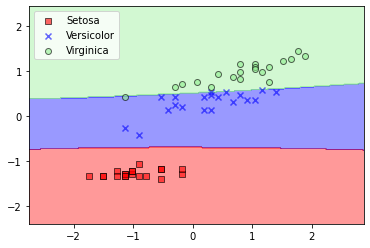

<ipython-input-6-1c1901332ddf>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print('Train Destiller: ', np.sum(destiller_no.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
<ipython-input-6-1c1901332ddf>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print('Test Destiller: ', np.sum(destiller_no.predict(x_test) == 

Train Destiller:  0.9333333333333333
Test Destiller:  0.9333333333333333
(243, 282)


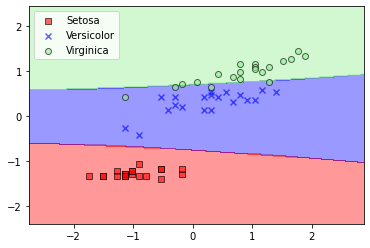

In [6]:
epochs = 900

i=0
# while i < 20:
  # i+=1
destiller = Destiller(atlasNN, eta=0.004, epochs=epochs, adapter_weights=melted_weights, adapter_bias=bias)

destiller_no = Destiller(atlasNN, eta=0.004, epochs=epochs, adapter_weights=None, adapter_bias=None)


###

destiller.fit(x_train, y_train, temperature=3, alpha=0.1)

print('Train Destiller: ', np.sum(destiller.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test Destiller: ', np.sum(destiller.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

destiller.plot_compresed_decision_regions(x_test, y_test)


destiller_no.fit(x_train, y_train, temperature=3, alpha=0.1)

print('Train Destiller: ', np.sum(destiller_no.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test Destiller: ', np.sum(destiller_no.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

destiller_no.plot_compresed_decision_regions(x_test, y_test)


In [ ]:
def plot_compressed_decision_regions(model, x, y):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    pca = PCA(n_components = 1)
    #merge 1 and 2

    x12 = pca.fit_transform(x[:, [0, 1]])
    create_subplot(model, x, y, x12, x[:, 2])
    #merge 2 and 3

    x23 = pca.fit_transform(x[:, [1, 2]])

    #merge 1 and 3

    x13 = pca.fit_transform(x[:, [0, 2]])

    
def create_subplot(model, data, labels, composite_axis, third_axis, resolution=0.2):
    x1_min, x1_max = composite_axis[:, 0].min() - 1, composite_axis[:, 0].max() + 1
    x2_min, x2_max = third_axis[:].min() - 1, third_axis[:].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    z = model.predict(data)
    z = z.reshape(xx1.shape)

    # print(xx1.shape)
    # print(xx2.shape)
    # print(np.array([xx1.ravel(), xx2.ravel(), xx3.ravel()]).T.shape)

    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=data[y == cl, 0], y=data[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=a[cl],
                        edgecolors='black')
    plt.legend(loc='upper left')
    plt.show()


In [ ]:


# plot_compressed_decision_regions(destiller, x_test, y_test)

print('Train Destiller: ', np.sum(destiller.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test Destiller: ', np.sum(destiller.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])


print('Train Destiller No Adapter: ', np.sum(destiller_no_adapter.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test Destiller No Adapter: ', np.sum(destiller_no_adapter.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

# Nowa sekcja

In [ ]:
import numpy as np
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a)

print(np.sum(a, axis = 1, keepdims = True))


indexes_to_remove = []
logistic_labels = np.array([[1, 0, 0], [1, 1, 1], [0, 0, 1], [1, 1, 1]])
for idx, val in enumerate(logistic_labels):
  first_label = val[0]
  if len(val[val == first_label]) == len(val):
    indexes_to_remove.append(idx)


# print(np.delete(logistic_labels, indexes_to_remove, axis=0))

x_data = [[-0.7795133,   0.08070915,  0.26414192],
          [ 2.4920192,   1.50164482,  1.05393502],
          [-0.41600969, -1.34022653, -1.3154443 ]]
y_data = [1, 2, 0]


# epochs = 900

# i=0
# # while i < 20:
#   # i+=1
# destiller = Destiller(atlasNN, eta=0.004, epochs=epochs, adapter_weights=melted_weights, adapter_bias=bias)

# destiller_no_adapter = Destiller(atlasNN, eta=0.003, epochs=epochs, adapter_weights=None, adapter_bias=bias)

# destiller.fit(x_train, y_train, temperature=3, alpha=0.1)

# destiller_no_adapter.fit(x_train, y_train, temperature=3, alpha=0.1)

# print('Train Destiller: ', np.sum(destiller.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
# print('Test Destiller: ', np.sum(destiller.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])


# destiller.plot_compresed_decision_regions(x_test, y_test)

# # destiller_no_adapter.plot_compresed_decision_regions(x_test, y_test)


# # print('Train Destiller: ', np.sum(destiller.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
# # print('Test Destiller: ', np.sum(destiller.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

# print('Train Destiller No Adapter: ', np.sum(destiller_no_adapter.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
# print('Test Destiller No Adapter: ', np.sum(destiller_no_adapter.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

# destiller_no_adapter.plot_compresed_decision_regions(x_test, y_test)


logistic_regression_results = []
for idx, unique_label in enumerate((np.unique(y_data))):
  logistic_labels = []
  for i, data_label in enumerate(y_data):
    if data_label == unique_label:
      logistic_labels.append(1)
    else:
      logistic_labels.append(0)
  try:
      print(f'Labels for {unique_label}')
      # print(y_data)
      print(logistic_labels)
      indexes_to_remove = []
      print(len(logistic_labels[logistic_labels == 1]))
        # if len(val[val == first_label]) == len(val):
        #   indexes_to_remove.append(idx)
      # filtered_data = np.delete(x_data, indexes_to_remove, axis=0)
      # logistic_labels = np.delete(np.array(logistic_labels), indexes_to_remove, axis=0)

      # logistic_regression_results.append(lr.fit(filtered_data, logistic_labels).coef_)
      # print(logistic_regression_results)
  except Exception as e:
    print("Logistic Regression exception occured: "+str(e))

In [ ]:
def addition(args):
  print(args[1])
  return sum(args)
 
print(addition([5, 10, 20, 6]))